In [19]:
import time
import random
import pandas as pd
import utils
import itertools

from typing import List, Tuple, Union
from pytrends.request import TrendReq
from matplotlib import pyplot as plt
from tqdm import tqdm

# Vizu settings
%matplotlib inline
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 6)

random.seed(1337)

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
LANGUAGE = 'en-US'
TIME_ZONE = 360

In [22]:
pytrends = TrendReq(hl=LANGUAGE, tz=TIME_ZONE)

In [23]:
COUNTRIES = utils.load_countries(filename="countries.txt", ignore="ignore.txt")

In [61]:
def get_interest_over_time(kw_list: List[str], tf: str, geo: str, sleep: float = 0.25) -> Union[pd.DataFrame, pd.Series]:
    time.sleep(sleep)
    pytrends.build_payload(kw_list, timeframe=tf, geo=geo)
    datablock = pytrends.interest_over_time()
    if datablock.empty:
        raise ValueError(f"Dropping dataframe for {kw_list} for geocode: {geo}")
    return datablock.drop(columns=['isPartial'])

def plot_history(plotting_data: list, search_terms: List[str]) -> None:
    titles, legends, datas = plotting_data

    for _title in zip(titles):
        plt.figure()
        plt.plot(datas, label=legends)
        plt.title(_title)
        plt.xlabel("Date")
        plt.ylabel("Interest")
        plt.grid(True)
        plt.legend(legends)

    plt.show()

    # for result in [results]:
    #     for search_term in search_terms:
    #         plt.figure()
    #         for label, pd_history in result:
    #             plt.plot(pd_history, label=label)
    #         plt.ylabel("Interest")
    #         plt.xlabel("Time")
    #         plt.legend(loc="upper right")
    #         plt.title(f"{search_term.capitalize()}: Interest Over Time")

def create_plot_data(history, search_terms):
    titles = search_terms
    legends = [country[0] for country in history]
    datas = [country[1] for country in history]
    return [titles, legends, datas]

def get_yearly_interest_by_country(search_terms: List[str],
                                   year: int,
                                   geocode: str,
                                   fetch_interval: int = 1) -> Union[pd.Series, pd.DataFrame]:
    history = []
    first_six_months = f"{year}-1-1 {year}-6-30"
    last_six_months = f"{year}-7-1 {year}-12-31"
    
    for time_period in [first_six_months, last_six_months]:
        history_frame = get_interest_over_time(search_terms, time_period, geocode, fetch_interval)
        history.append(history_frame)

    year_of_data = pd.concat(history)
    assert year_of_data.shape[0] == 365, "Expected 365 days in a year!"

    return year_of_data

def get_daily_trends_by_year(search_terms: List[str], year: int, countries: Union[int, List[str]], fetch_interval: int = 1) -> List[Tuple[str, Union[pd.DataFrame, pd.Series]]]:
    utils.check_is_valid_indexing(countries)

    search_countries = get_sampled_countries(countries=countries)

    history = []

    for geocode, country in tqdm(search_countries, desc="Fetching trends", nrows=n_countries, colour="green"):
        try:
            history_frame = get_yearly_interest_by_country(search_terms, year, geocode, fetch_interval)
        except ValueError as ve:
            print(ve)
            continue # continue if empty
        history.append((country, history_frame))
    return history
    
def get_sampled_countries(countries: Union[int, List[str]]):
    if isinstance(countries, int):
        if countries == 0:
            return COUNTRIES
        else:
            return random.sample(COUNTRIES, countries)
    elif isinstance(countries, List):
        raise NotImplementedError("TODO")
    

In [62]:
year = 2015
search_terms = ["yoghurt", "cheese"]
n_countries = 3           # 0 = all
fetch_interval = 1       # sleep time between requests

history = get_daily_trends_by_year(search_terms, year, n_countries, fetch_interval)

Checking type:  <class 'int'>


Fetching trends: 100%|██████████| 3/3 [00:09<00:00,  3.29s/it]


### Vizualize: TODO FIX THIS PLOTTING SHITT

In [63]:
plotting_data = create_plot_data(history, search_terms)

ValueError: x and y can be no greater than 2D, but have shapes (3,) and (3, 365, 2)

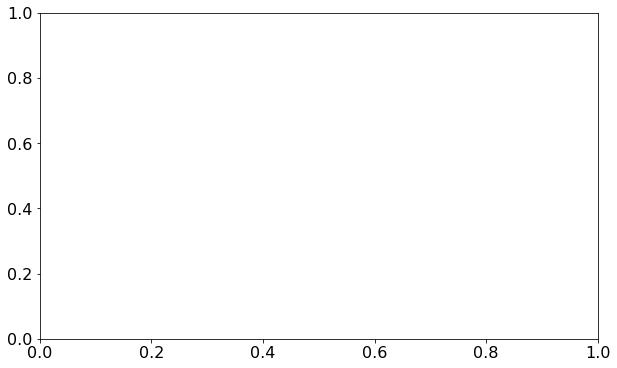

In [64]:
plot_history(plotting_data, search_terms)